# 1D Bouncing Ball

*   [Done] Set up 1D bouncing ball, single layer and bootstrap hvar patterns.
*   [Done] Implement clock. Automatically advance registered iterators with clock ticks. Implement trace iterator that can accumulate tract with clock ticks.
*   [Done] Maintain a queue of previous T signals
*   [Done] In forward, compare both beginning and ending of trajectory ($\mu_{t-\tau}$, $\mu_{t}$)
*   [Done] Compare $\mu$ at the beginning of cycle and allow the winner to predict rest of the cycle.
*   [Done] Implement winner refractory period. All refractory factors are restored 10% every time step (e.g. 0.8 becomes 0.88, 0.97, and so on). Winner gets 0.8.
*   [Done] refractory handicap should be applied by multiplying similarily score with the handicap before softmax and winner sampling.
*   Should each layer's theta cycle be same time steps long, or longer for higher layers? It has to be same, otherwise semantics of what is current and what is predicted would get mixed up across layers.
*   Add whitening to signals before pattern comparison -- NO. Instead add smooth (exponentially adapting) gain control on sensory input only. In rest of the system, amplitude = confidence, so can't normalize. A little bit of contrast enhancement (mediated through lateral inh?) is okay.
*   Implement second layer. Higher layer with longer trace? For the lower layer, figure out how to handle own intra-cycle predictions and the top-down predictions. Compare \$mu\ intra cycle as well with only the output neighborhood signal at high precision, sensory/other modalities clamped at low precision?


## Experiment

Visual input is shaped 1x4 pixels. Background pixels are 0 and a single ball represented by a 1 pixel. For example 0001 represents state where the ball is at the right end. The ball is moving from left to right and back in a continuous loop, advancing 1 step at a time. 1000 -> 0100 -> 0010 -> 0001 -> 0010 -> 0100 and so on.

Lets say that theta activity cycles have a period of $T=4$. We expect pattern machine to learn trajectories where beginning and ending are 4 steps apart. Given we are not training yet, we will manually set up such trajectories to bootstrap. The trajectories will be -
1)   trace(1000) -> trace(0001) because 1000->0100->0010->0001 are 4 steps
2)   trace(0001) -> trace(1000) because 0001->0010->0100->1000 are 4 steps

At the beginning of a theta cycle, a winning pattern is selected. That pattern's trajectory is interpolated through the next $T-1$ steps. If pattern 1 is the winner then, the interpolation would be 0100, 0010 and 0001. Error between this prediction and actual input is accumulated through the cycle.

Given we bootstrapped patterns to match reality, we expect low error.

In [1]:
import pdb
import sys
sys.path.append('/Users/amolk/work/AGI/pattern-machine/src')
%load_ext autoreload
%autoreload 1
from IPython.display import display
print = display


%aimport patternmachine.layer
%aimport patternmachine.signal_grid_set
%aimport patternmachine.signal_utils
%aimport patternmachine.trace
%aimport patternmachine.pattern_similarity
%aimport patternmachine.pattern_grid
%aimport patternmachine.clock
%aimport patternmachine.utils

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

def show_1d_image(image, title=None):
    assert len(image.shape) == 1
    fig=plt.figure(figsize=(2, 1))
    plt.axis('off')
#     ax = fig.add_subplot(111)
    if title is not None:
        plt.title(label=title)
    plt.imshow(image.unsqueeze(0), vmin=0, vmax=1)
#     ax.set_aspect('equal')
#     plt.tight_layout(pad=0)
    plt.show()
    
def show_2d_image(image, title=None):
    assert len(image.shape) == 2
    plt.axis('off')
    if title is not None:
        plt.title(label=title)
    plt.imshow(image)
    plt.show()

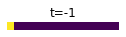

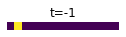

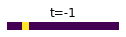

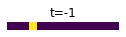

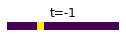

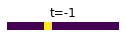

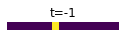

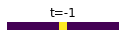

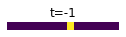

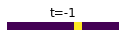

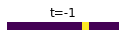

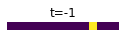

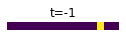

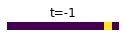

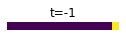

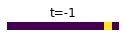

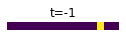

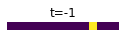

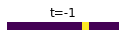

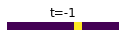

In [3]:
import torch
from patternmachine.clock import Clock

class BouncingBall1D:
    def __init__(self, width=15, init_position=0):
        self.width = width
        self.init_position = init_position
        self.position = None
        self.paused = False
        
    def make_signal(self, position):
        signal = torch.zeros((self.width,))
        if position <= self.width - 1:
            signal[position] = 1.0
        else:
            signal[self.width - position - 2] = 1.0
        return signal
    
    def reset(self):
        self.position = None

    def pause(self):
        self.paused = True

    def unpause(self):
        self.paused = False
        
    @property
    def current(self):
        if self.position is None:
            return self.make_signal(self.init_position)
        return self.make_signal(self.position)
        
    def next(self, clock:Clock):
        if self.position is None:
            self.position = self.init_position
        else:
            if not self.paused:
                self.position = (self.position + 1) % (self.width * 2 - 2)

        return_value = self.current

        return return_value

env = BouncingBall1D()
clock = Clock(tau=2)
for _ in range(20):
    show_1d_image(env.next(clock), title=f"t={clock.t}")

'EXPERIMENTS:'

'Experiment 1'

'Traces'

'Simulating training...'

'Done'

'Patterns begin'

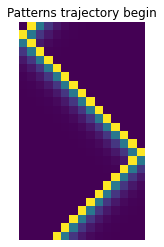

'Patterns end'

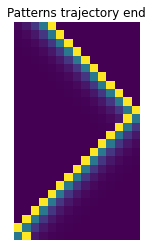

'Starting at an ambiguous initial state where going left or right are equally probable'

'Pausing the ball so we see repeated predictions from the same initial position'

'tau = '

5

'Clock time 0'

0

'Start of cycle'

'experiment.layer.top_down_winner_index'

tensor([8])

'experiment.layer.top_down_winner_refractory_handicap'

tensor([[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.8000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000]])

'Input:'

'Prediction:'

'--------------------'

'Clock time 1'

1

'Input:'

'Prediction:'

'--------------------'

'Clock time 2'

2

'Input:'

'Prediction:'

'--------------------'

'Clock time 3'

3

'Input:'

'Prediction:'

'--------------------'

'Clock time 4'

4

'Input:'

'Prediction:'

'--------------------'

'Clock time 5'

5

'Input:'

'Prediction:'

'--------------------'

'Clock time 6'

0

'Start of cycle'

'experiment.layer.top_down_winner_index'

tensor([22])

'experiment.layer.top_down_winner_refractory_handicap'

tensor([[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.8800,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 0.8000, 1.0000, 1.0000, 1.0000]])

'Input:'

'Prediction:'

'--------------------'

'Clock time 7'

1

'Input:'

'Prediction:'

'--------------------'

'Clock time 8'

2

'Input:'

'Prediction:'

'--------------------'

'Clock time 9'

3

'Input:'

'Prediction:'

'--------------------'

'Clock time 10'

4

'Input:'

'Prediction:'

'--------------------'

'Clock time 11'

5

'Input:'

'Prediction:'

'--------------------'

'Clock time 12'

0

'Start of cycle'

'experiment.layer.top_down_winner_index'

tensor([8])

'experiment.layer.top_down_winner_refractory_handicap'

tensor([[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.8000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 0.8800, 1.0000, 1.0000, 1.0000]])

'Input:'

'Prediction:'

'--------------------'

'Clock time 13'

1

'Input:'

'Prediction:'

'--------------------'

'Clock time 14'

2

'Input:'

'Prediction:'

'--------------------'

'Clock time 15'

3

'Input:'

'Prediction:'

'--------------------'

'Clock time 16'

4

'Input:'

'Prediction:'

'--------------------'

'Clock time 17'

5

'Input:'

'Prediction:'

'--------------------'

'Clock time 18'

0

'Start of cycle'

'experiment.layer.top_down_winner_index'

tensor([22])

'experiment.layer.top_down_winner_refractory_handicap'

tensor([[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.8800,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 0.8000, 1.0000, 1.0000, 1.0000]])

'Input:'

'Prediction:'

'--------------------'

'Clock time 19'

1

'Input:'

'Prediction:'

'--------------------'

'Clock time 20'

2

'Input:'

'Prediction:'

'--------------------'

'Clock time 21'

3

'Input:'

'Prediction:'

'--------------------'

'Clock time 22'

4

'Input:'

'Prediction:'

'--------------------'

'Clock time 23'

5

'Input:'

'Prediction:'

'--------------------'

'Clock time 24'

0

'Start of cycle'

'experiment.layer.top_down_winner_index'

tensor([8])

'experiment.layer.top_down_winner_refractory_handicap'

tensor([[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.8000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 0.8800, 1.0000, 1.0000, 1.0000]])

'Input:'

'Prediction:'

'--------------------'

'Clock time 25'

1

'Input:'

'Prediction:'

'--------------------'

'Clock time 26'

2

'Input:'

'Prediction:'

'--------------------'

'Clock time 27'

3

'Input:'

'Prediction:'

'--------------------'

'Clock time 28'

4

'Input:'

'Prediction:'

'--------------------'

'Clock time 29'

5

'Input:'

'Prediction:'

'--------------------'

In [4]:
from patternmachine.layer import Layer, LayerHP
from patternmachine.signal_grid_set import SignalGridSet
from patternmachine.signal_utils import SignalUtils
from patternmachine.trace import Trace, TraceIterator
from patternmachine.clock import Clock

class BouncingBall1DExperiment:
    def __init__(self, tau):
        self.tau = tau
        self.clock = Clock(tau=tau)
        self.signal_width = 15
        
        self.env = BouncingBall1D(width=self.signal_width)
        self.env_trace = TraceIterator(self.env, epsilon=0.6)

        self.clock.register(self.env)
        self.clock.register(self.env_trace)
        
        self.pattern_count = self.env.width * 2 + 1 - self.tau
        
        self.input_shape = (self.signal_width, 1)
        self.layer_hp = LayerHP(
            
            input_signal_shapes={"env":self.input_shape},
            
            input_coverage_factor=1.0,
            patch_grid_shape=(1, 1), # see the whole input
            
            per_patch_pattern_grid_shape=(1, self.pattern_count),
        
            output_patch_neighborhood_shape=(1, 1),
            
            output_decay=1.0
        )
        self.layer = Layer(hp=self.layer_hp, inputs={"env": self.env_trace})

        self.bootstrap_hvars(self.layer)
        
        self.env.reset()
        self.env_trace.reset()
        self.clock.reset()
        self.clock.register(self.layer)
        
    def bootstrap_hvars(self, layer):
        traces = []
        trace = Trace(self.env.next(self.clock), epsilon=0.6)

        # warmup
        for _ in range(self.pattern_count):
            trace.trace_(self.env.next(self.clock))
        
        # gather
        print("Traces")
        for _ in range(self.pattern_count + self.tau):
            trace.trace_(self.env.next(self.clock))
            show_1d_image(trace)
            traces.append(trace.clone())
        
        self.traces = traces
        
        # we will get 6 patterns here with T=1
        # traces[0]->traces[1] will be a pattern,
        # upto traces[5]->traces[6]
        # print("Patterns are initialized randomly -")
        # print("Patterns begin")
        # show_2d_image(layer.patterns.pixels_begin.components["env"].pixels)

        # print("Patterns end")
        # show_2d_image(layer.patterns.pixels_end.components["env"].pixels)

        print("Simulating training...")
        for i in range(self.pattern_count):
            # start of trajectory
            layer.patterns.pixels_begin.components["env"].pixels[i] = traces[i]
            layer.patterns.precision_begin.components["env"].pixels[i] = torch.ones_like(traces[i])
            layer.patterns.precision_begin.components["__output__"].pixels[i] *= 0 # ignore output with 0 precision

            # end of trajectory
            end_index = i + self.tau
            layer.patterns.pixels_end.components["env"].pixels[i] = traces[end_index]

            layer.patterns.precision_end.components["env"].pixels[i] = torch.ones_like(traces[end_index])
            layer.patterns.precision_end.components["__output__"].pixels[i] *= 0 # ignore output with 0 precision

        print("Done")
        print()
            
        print("Patterns begin")
        show_2d_image(layer.patterns.pixels_begin.components["env"].pixels, title="Patterns trajectory begin")
        print("Patterns end")
        show_2d_image(layer.patterns.pixels_end.components["env"].pixels, title="Patterns trajectory end")


print("EXPERIMENTS:")

print("Experiment 1")
experiment = BouncingBall1DExperiment(tau=5)

print("Starting at an ambiguous initial state where going left or right are equally probable")
experiment.env.init_position = 7
print("Pausing the ball so we see repeated predictions from the same initial position")
experiment.env.pause()
print("tau = ", experiment.tau)
print()

cycle_count = 5
for i in range((experiment.clock.tau + 1) * cycle_count):
    experiment.clock.tick()
    print(f"Clock time {experiment.clock.t}")

    print(experiment.clock.t % (experiment.clock.tau + 1))
    if experiment.clock.t % (experiment.clock.tau + 1) == 0:
        print("Start of cycle")
        print("experiment.layer.top_down_winner_index")
        print(experiment.layer.top_down_winner_index)
        print("experiment.layer.top_down_winner_refractory_handicap")
        print(experiment.layer.top_down_winner_refractory_handicap.pixels)
    print("Input:")
    show_1d_image(experiment.env_trace.current(clock=clock))

    print("Prediction:")
    prediction = experiment.layer.current(clock=experiment.clock)
    # print(prediction["env"].squeeze())
    show_1d_image(prediction["env"].squeeze())

    print("-" * 20)


Notice winner indices 8, 22, 8, 22, 8, i.e. alternating between two possible futures!